# Convolutional Autoencoder

Using convolutional autoencoder to extract general features from our molecular images. We only have 160 images associated with eyetracking data, which is far not enough for training a CNN. So, we generate similar images with Jmol (software for chemical structures) as additional trainning examples with no labels.   

In [1]:
%matplotlib inline
import time
#from IPython.display import clear_output, Image, display, HTML
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
from scipy import misc
import tensorflow as tf
import matplotlib.pyplot as plt

In [18]:
WIDTH  = 256
HEIGHT = 256
NUM_CHANNELS = 1
layer1_width = 256/2
layer1_height = 256/2
layer2_width = 256/4
layer2_height = 256/4

s = tf.constant(2)
t = tf.constant(5)
phase_train= tf.less(s, t)
epsilon = 1e-3

IMG_FORMAT=".jpeg"
PATH="../data/LENS/augment/"

## Prepare data
I'd like to operate image data in pure tensorflow enviroment, using tf reader. I can read into images and make a batch of them, but the trainning cost is so much high.

In [3]:
def load_images():   
    
    im_arrays = []
    # Image from PIL library can read an image file as image, then we can operate the image, like resize and grayscale.
    imfilelist=[os.path.join(PATH,f) for f in os.listdir(PATH) if f.endswith(IMG_FORMAT)]

    for el in imfilelist:
        #print el
        img = Image.open(el)
        #print img.format, img.size, img.mode
        img = img.convert('L')
        img = img.resize((WIDTH, HEIGHT), resample=2)
        im_array = np.array(img)  
        # Normalization: The inputs come in as uint8, we need to convert them to float32 in range [0,1].      
        im_array = im_array / np.float32(255)  
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (rows, columns, channels)
        im_array = im_array.reshape(WIDTH, HEIGHT, NUM_CHANNELS)
        im_arrays.append(im_array)

    return np.array(im_arrays)

#split data into training, validation and testing set
def split_data(inputs_):
    
    X_train, X_test = train_test_split(inputs_, test_size=16, shuffle=True)
    X_train, X_validation = train_test_split(X_train, test_size=100, shuffle=True)
    return X_train, X_validation, X_test

#display a few images for sanity check
def check_data(inputs_):
    
    fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
    ax = ax.flatten()
    for i in range(5):
        img = inputs_[i]
        if(NUM_CHANNELS == 1):
            ax[i].imshow(np.array(img).reshape(WIDTH, HEIGHT), cmap='Greys_r')
        else:
            ax[i].imshow(np.array(img).reshape(WIDTH, HEIGHT, NUM_CHANNELS))
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        fig.tight_layout(pad=0.1)

#get batch data for training
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            #print(excerpt)
        yield inputs[excerpt]

('X_train:', (1800, 256, 256, 1))
('X_validation:', (100, 256, 256, 1))
('X_test:', (16, 256, 256, 1))


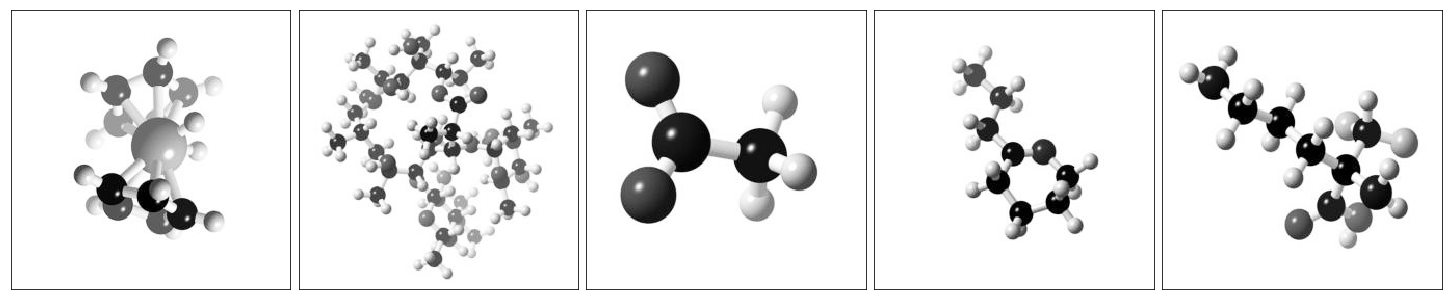

In [4]:
X_data = load_images()
X_train, X_validation, X_test = split_data(X_data)
print("X_train:", X_train.shape)
print("X_validation:", X_validation.shape)
print("X_test:", X_test.shape)
check_data(X_train)

### Build the network

Now we can put all the pieces together and build a class for the network.

In [22]:
def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        
        batch_mean2, batch_var2 = tf.nn.moments(x,[0])
        scale2 = tf.Variable(tf.ones([n_out]))
        beta2 = tf.Variable(tf.zeros([n_out]))
        BN2 = tf.nn.batch_normalization(x,batch_mean2,batch_var2,beta2,scale2,epsilon)
        #l2_BN = tf.nn.sigmoid(BN2)
        
        
         #beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
         #                             name='beta', trainable=True)
         #gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
         #                              name='gamma', trainable=True)
         #batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
         #ema = tf.train.ExponentialMovingAverage(decay=0.5)
 #
         #def mean_var_with_update():
         #    ema_apply_op = ema.apply([batch_mean, batch_var])
         #    with tf.control_dependencies([ema_apply_op]):
         #        return tf.identity(batch_mean), tf.identity(batch_var)
 #
         #mean, var = tf.cond(phase_train,
         #                    mean_var_with_update,
         #                    lambda: (ema.average(batch_mean), ema.average(batch_var)))
         #normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return BN2

In [23]:
class conv_autoencoder(object):
    
    def __init__(self, batch_size=10, learning_rate=0.001, skip_layer=[''], weights_path='DEFAULT'):    

        #This cell should be executed only once, otherwise, tensorflow will raise an error
        #(Variable conv1/weights already exists) because the graph (with it's layer names)
        #already exists. So I add the following command to reset graph.
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs = self.build_inputs()

        if weights_path == 'DEFAULT':
            self.WEIGHTS_PATH = 'ae_weights.npz'
        else:
            self.WEIGHTS_PATH = weights_path
            
        self.SKIP_LAYER = skip_layer
        
        # Build the autoencoder
        self.reconstructed, self.logits = self.build_autoencoder(self.inputs)
        
        # Loss and optimizer
        self.global_step = tf.Variable(0, dtype = tf.int32, trainable = False, name = 'global_step')
        self.loss = self.build_loss(self.logits, self.inputs)
        self.optimizer = self.build_optimizer(self.loss, learning_rate, self.global_step)
    
    def build_inputs(self):
        ''' Define placeholders for inputs, targets
       
        '''   
        # Declare placeholders we'll feed into the graph
        inputs = tf.placeholder(tf.float32, (None, WIDTH, HEIGHT, NUM_CHANNELS), name='inputs')
        return inputs
    
    #Create a conv network with 3 conv layers as an encoder
    def encoder(self, input_):
        #Conv 1: filter: [3, 3, 1, 16], stride: [2, 2], relu
        with tf.variable_scope('conv1') as scope:
            weights = tf.get_variable('weights', [3,3,1,16])
            #biases = tf.get_variable('biases', [16], initializer = tf.random_normal_initializer())
            conv = tf.nn.conv2d(input_, weights, strides = [1,1,1,1], padding = 'SAME')
            conv_bn = batch_norm(conv, 16, phase_train)
            #conv1= tf.nn.relu(conv + biases, name = scope.name)
            conv1= tf.nn.relu(conv_bn, name = scope.name)
            print ('conv1 shape:', conv1.get_shape().as_list())
            
        with tf.variable_scope('pool1') as scope:
            pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            print ('pool1 shape:', pool1.get_shape().as_list())
        
        with tf.variable_scope('conv2') as scope:
            weights = tf.get_variable('weights', [3,3,16,8])
            biases = tf.get_variable('biases', [8], initializer = tf.random_normal_initializer())
            conv = tf.nn.conv2d(pool1, weights, strides = [1,1,1,1], padding = 'SAME')
            conv_bn = batch_norm(conv, 8, phase_train)
            #conv2 = tf.nn.relu(conv + biases, name = scope.name)
            conv2 = tf.nn.relu(conv_bn, name = scope.name)
            print ('conv2 shape:', conv2.get_shape().as_list())
            
        with tf.variable_scope('pool2') as scope:
            pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            print ('pool2 shape:', pool2.get_shape().as_list())
            
        with tf.variable_scope('conv3') as scope:
            weights = tf.get_variable('weights', [3,3,8,8])
            biases = tf.get_variable('biases', [8], initializer = tf.random_normal_initializer())
            conv = tf.nn.conv2d(pool2, weights, strides = [1,1,1,1], padding = 'SAME')
            conv_bn = batch_norm(conv, 8, phase_train)
            #conv3 = tf.nn.relu(conv + biases, name = scope.name)
            conv3 = tf.nn.relu(conv_bn, name = scope.name)
            print ('conv3 shape:', conv3.get_shape().as_list())
        
        with tf.variable_scope('encoded') as scope:
            encoded = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            print ('encoded shape:', encoded.get_shape().as_list())
            
            return encoded
    
    def decoder(self, input_):
    
        with tf.variable_scope('upsample1') as scope:
            upsample1 = tf.image.resize_bilinear(input_, ((layer2_width, layer2_height)))
        
        with tf.variable_scope('deconv1') as scope:
            weights = tf.get_variable('weights', [3,3,8,8])
            biases = tf.get_variable('biases', [8], initializer = tf.random_normal_initializer())
            deconv = tf.nn.conv2d(upsample1, weights, strides = [1,1,1,1], padding = 'SAME')
            deconv_bn = batch_norm(deconv, 8, phase_train)
            #deconv1 = tf.nn.relu(deconv + biases, name = scope.name)
            deconv1 = tf.nn.relu(deconv_bn, name = scope.name)
            
        with tf.variable_scope('upsample2') as scope:
            upsample2 = tf.image.resize_bilinear(deconv1, ((layer1_width, layer1_height)))
        
        with tf.variable_scope('deconv2') as scope:
            weights = tf.get_variable('weights', [3,3,8,8])
            biases = tf.get_variable('biases', [8], initializer = tf.random_normal_initializer())
            deconv = tf.nn.conv2d(upsample2, weights, strides = [1,1,1,1], padding = 'SAME')
            deconv_bn = batch_norm(deconv, 8, phase_train)
            #deconv2 = tf.nn.relu(deconv + biases, name = scope.name)
            deconv2 = tf.nn.relu(deconv_bn, name = scope.name)
            
        with tf.variable_scope('upsample3') as scope:
            upsample3 = tf.image.resize_bilinear(deconv2, ((WIDTH, HEIGHT)))
        
        with tf.variable_scope('deconv3') as scope:
            weights = tf.get_variable('weights', [3,3,8,16])
            biases = tf.get_variable('biases', [16], initializer = tf.random_normal_initializer())
            deconv = tf.nn.conv2d(upsample3, weights, strides = [1,1,1,1], padding = 'SAME')
            deconv_bn = batch_norm(deconv, 16, phase_train)
            deconv3 = tf.nn.relu(deconv_bn, name = scope.name)
            
        with tf.variable_scope('decoded') as scope:
            weights = tf.get_variable('weights', [3,3,16,1])
            biases = tf.get_variable('biases', [1], initializer = tf.random_normal_initializer())
            logits = tf.nn.conv2d(deconv3, weights, strides = [1,1,1,1], padding='SAME')
            logits = batch_norm(logits, 1, phase_train)
            decoded = tf.nn.sigmoid(logits, name = scope.name)       
            
            return decoded, logits       

    def build_autoencoder(self, input_):
       
        # Define variable scope for autoencoder
        #with tf.variable_scope('autoencoder') as scope:
        
        # Pass input to encoder to obtain encoded
        encoded = self.encoder(input_)
        # Pass encoding into decoder to obtain reconstructed image
        decoded, logits = self.decoder(encoded)
        # Return input image (placeholder) and reconstructed image        
        return decoded, logits
    
    def build_loss(self, logits, targets):
        ''' Calculate the loss from the logits and the targets.
        
            Arguments
            ---------
            logits: Logits from final fully connected layer
            targets: Targets for supervised learning
            
        '''
    
        # use sigmoid cross entropy with logits as the loss function
        # compute mean cross entropy, sigmoid is applied internally
        with tf.name_scope('loss'):
            cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
            loss = tf.reduce_mean(cost)
            return loss
    
    def build_optimizer(self, loss, learning_rate, steps):
        ''' Build optmizer for training.
        
            Arguments:
            cost: Network loss
            learning_rate: Learning rate for optimizer
        
        '''
        
        # Optimizer: set up a variable that's incremented once per batch and controls the learning rate decay.
        # Decay once per epoch, using an exponential schedule starting at 0.01.
        #batch = tf.Variable(0)
        #train_size = len(X_train)
        #learning_rate = tf.train.exponential_decay(
        #                                       0.001,               # Base learning rate.
        #                                       batch * BATCH_SIZE,  # Current index into the dataset.
        #                                       train_size,          # Decay step.
        #                                       0.85,                # Decay rate.
        #                                       staircase=True)
        
        # using gradient descent with learning rate of LEARNING_RATE to minimize cost
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step = steps)   
        return opt
    
    #
    def load_initial_weights(self, session):
        """Load weights from file into network instead of training the network.
    
        """
        # Load the weights into memory
        weights_dict = np.load(self.WEIGHTS_PATH)
        
        # Loop over all layer names stored in the weights dict
        for op_name in weights_dict:
            #print('op_name:', op_name)
            op_name_1 = op_name.split('/')[0]
            op_name_2 = (op_name.split('/')[1]).split(':')[0]
            # Check if layer should be trained from scratch
            if op_name_1 not in self.SKIP_LAYER:
                with tf.variable_scope(op_name_1, reuse=True):
                    
                    var = tf.get_variable(op_name_2, trainable=False)
                    #print('var name:', var.op.name)
                    data = weights_dict[op_name]
                    session.run(var.assign(data))

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. And every so often (set by `save_every_n`) I save a checkpoint.

In [ ]:
LEARNING_RATE = 0.01
BATCH_SIZE = 30
EPOCHS = 20
num_batch = len(X_train)//BATCH_SIZE
num_batch_val = len(X_validation)//BATCH_SIZE
train_layers = []

# Save every N iterations
save_every_n = 190
train_loss = []
validation_loss = []
test_loss = []

#If using tf data reader we simply use data_batch and lable_batch the way we have used input_placeholder
#and label_placeholder in the current model, except that we don't have to feed them in through feed_dict
#parameter. what we need to do is to feed them in autoencoder as inputs_
#data_batch = generate_batch()

model = conv_autoencoder(batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, skip_layer=train_layers)

with tf.name_scope('train'):
    train_loss_sum = tf.summary.scalar('train_loss', model.loss)
    #tf.summary.histogram('histogram_loss', model.loss)
    #summary_op = tf.summary.merge_all()

with tf.name_scope('val'):
    val_loss_sum = tf.summary.scalar('val_loss', model.loss)

saver = tf.train.Saver(max_to_keep=100)   
with tf.Session() as sess:
    
    writer  =  tf.summary.FileWriter('./graphs', sess.graph)
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/______.ckpt')
    counter = 0
    counter_val = 0
    # Start training network
    for e in range(EPOCHS):     
        avg_loss = 0.
        avg_loss_val = 0.
        for batch in iterate_minibatches(X_train, BATCH_SIZE, shuffle=True):
            counter += 1
            start = time.time()
            feed = {model.inputs: batch}
            batch_loss, _, summary = sess.run([model.loss, model.optimizer, train_loss_sum], feed_dict = feed)
            train_loss.append(batch_loss)
            avg_loss += batch_loss
            end = time.time()

            #writer.add_summary(summary, e*35+counter)
            writer.add_summary(summary, global_step=counter)
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/.ckpt", global_step = model.global_step)
         
        # validating model
        for batch_val in iterate_minibatches(X_validation, BATCH_SIZE, shuffle=False):
            counter_val += 1
            feed_val = {model.inputs: batch_val}
            batch_loss_val, summary = sess.run([model.loss, val_loss_sum], feed_dict = feed_val)
            validation_loss.append(batch_loss_val)
            avg_loss_val += batch_loss_val
            writer.add_summary(summary, global_step=counter_val)
            
        print('Epoch: {}/{}... '.format(e+1, EPOCHS),
              'Training Step: {}... '.format(counter),
              'Training/Val loss: {:.4f}/{:.4f}... '.format(avg_loss/num_batch, avg_loss_val/num_batch_val))
                          
    #saver.save(sess, "checkpoints/i{}.ckpt".format(counter), global_step = model.global_step)   
    # close the writer when you’re done using it
    writer.close()

('conv1 shape:', [None, 256, 256, 16])
('pool1 shape:', [None, 128, 128, 16])
('conv2 shape:', [None, 128, 128, 8])
('pool2 shape:', [None, 64, 64, 8])
('conv3 shape:', [None, 64, 64, 8])
('encoded shape:', [None, 32, 32, 8])
('Epoch: 1/20... ', 'Training Step: 60... ', 'Training/Val loss: 0.5301/0.4340... ')
('Epoch: 2/20... ', 'Training Step: 120... ', 'Training/Val loss: 0.3842/0.3377... ')
('Epoch: 3/20... ', 'Training Step: 180... ', 'Training/Val loss: 0.3091/0.2851... ')
('Epoch: 4/20... ', 'Training Step: 240... ', 'Training/Val loss: 0.2698/0.2573... ')
('Epoch: 5/20... ', 'Training Step: 300... ', 'Training/Val loss: 0.2426/0.2344... ')
('Epoch: 6/20... ', 'Training Step: 360... ', 'Training/Val loss: 0.2244/0.2201... ')
('Epoch: 7/20... ', 'Training Step: 420... ', 'Training/Val loss: 0.2100/0.2094... ')
('Epoch: 8/20... ', 'Training Step: 480... ', 'Training/Val loss: 0.2016/0.2016... ')
('Epoch: 9/20... ', 'Training Step: 540... ', 'Training/Val loss: 0.1927/0.1933... ')
(

1200
60


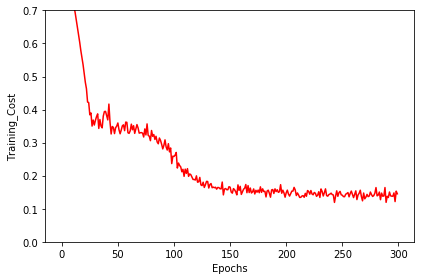

In [10]:
#tf.train.get_checkpoint_state('checkpoints')
print(len(train_loss))
print(len(validation_loss))
#print(validation_loss[-10:])
plt.plot(range(len(train_loss[:300])), train_loss[:300], color='red')
plt.ylim([0, 0.7])
plt.ylabel('Training_Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

## Testing

INFO:tensorflow:Restoring parameters from checkpoints/.ckpt-1140
Found variables:
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
conv3/weights:0
conv3/biases:0
deconv1/weights:0
deconv1/biases:0
deconv2/weights:0
deconv2/biases:0
deconv3/weights:0
deconv3/biases:0
decoded/weights:0
decoded/biases:0


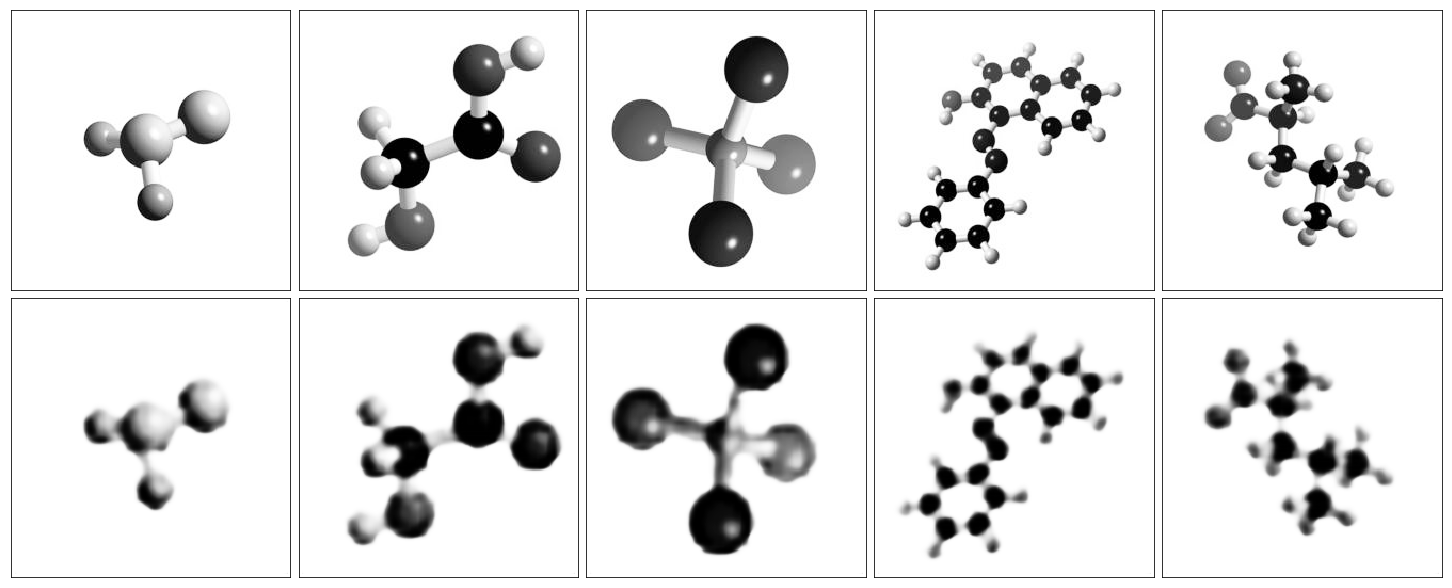

In [25]:
with tf.Session() as sess:
    #Reload Model from Checkpoint Files
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # ------------------------------------------------------------------------------#
    # export trained weights to numpy NPZ files for future use, like finetuning 
    var_names = [v.name for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)]    
    params = {}
    print('Found variables:')
    for v in var_names:
        print(v)       
        ary = sess.run(v)
        #dictionary type with key:value pairs
        params[v] = ary
        
    np.savez('ae_weights', **params)
    # ------------------------------------------------------------------------------#
    in_imgs = X_test[-5:]
    
    start = time.time()
    feed = {model.inputs: in_imgs}
    recons_imgs = sess.run([model.reconstructed], feed_dict=feed)
    recons_imgs = np.asarray(recons_imgs)
    recons_imgs = recons_imgs.reshape(-1,256,256,1)
    end = time.time()

    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,8))
    for images, row in zip([in_imgs, recons_imgs], axes):
        for img, ax in zip(images, row):
            #print(img.shape)
            if(NUM_CHANNELS == 1):
                ax.imshow(img.reshape((WIDTH, HEIGHT)), cmap='Greys_r')
            else:
                ax.imshow(img.reshape((WIDTH, HEIGHT, NUM_CHANNELS)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)

In [35]:
temp = np.load('ae_weights.npz')
for op_name in temp:
    #print(temp.keys().split('/')[0])
    print((op_name.split('/')[1]).split(':')[0])
temp.close()

biases
biases
weights
biases
biases
weights
weights
weights
biases
biases
weights
biases
weights
weights


('conv1 shape:', [None, 256, 256, 16])
('pool1 shape:', [None, 128, 128, 16])
('conv2 shape:', [None, 128, 128, 8])
('pool2 shape:', [None, 64, 64, 8])
('conv3 shape:', [None, 64, 64, 8])
('encoded shape:', [None, 32, 32, 8])
Found variables:
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
conv3/weights:0
conv3/biases:0
deconv1/weights:0
deconv1/biases:0
deconv2/weights:0
deconv2/biases:0
deconv3/weights:0
deconv3/biases:0
decoded/weights:0
decoded/biases:0
('op_name:', 'deconv3/biases:0')
('var name:', u'deconv3/biases')
('op_name:', 'conv1/biases:0')
('var name:', u'conv1/biases')
('op_name:', 'conv3/weights:0')
('var name:', u'conv3/weights')
('op_name:', 'conv3/biases:0')
('var name:', u'conv3/biases')
('op_name:', 'deconv2/biases:0')
('var name:', u'deconv2/biases')
('op_name:', 'deconv3/weights:0')
('var name:', u'deconv3/weights')
('op_name:', 'conv1/weights:0')
('var name:', u'conv1/weights')
('op_name:', 'deconv1/weights:0')
('var name:', u'deconv1/weights')
('op

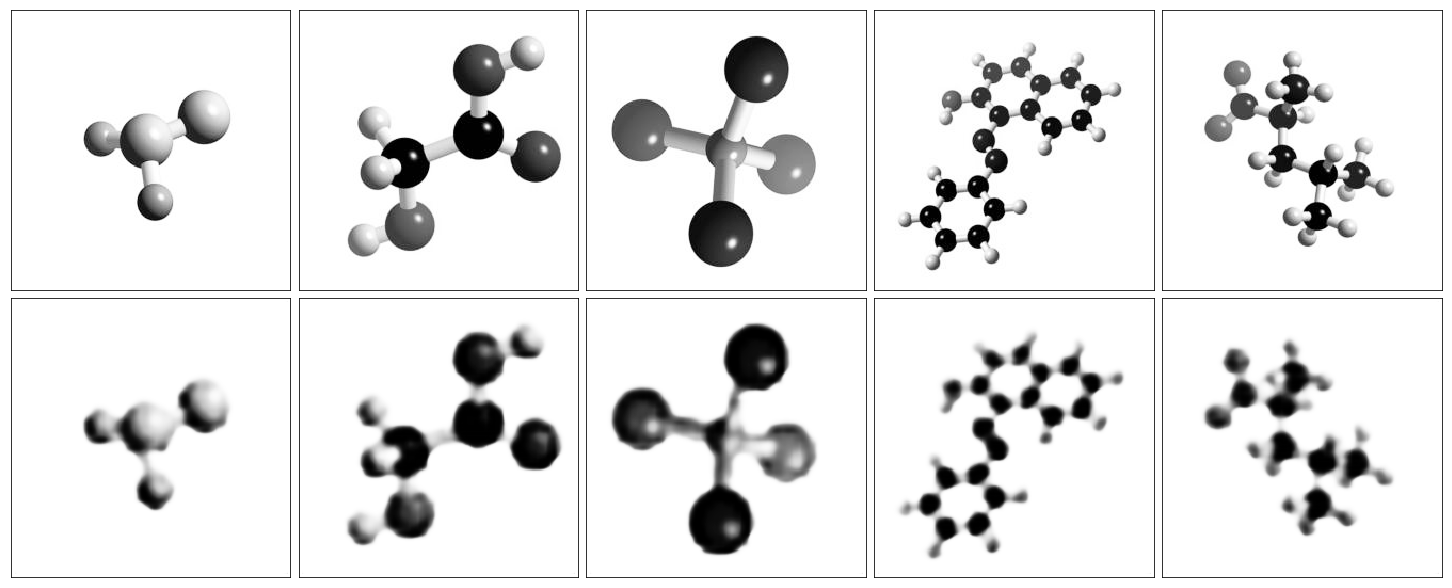

In [38]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 30
EPOCHS = 20
train_layers = []

#g = tf.Graph()
#with g.as_default():
model_test = conv_autoencoder(batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, skip_layer=train_layers)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    var_names = [v.name for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)]    
    print('Found variables:')
    for v in var_names:
        print(v)       
    
    
    model_test.load_initial_weights(sess)
    
    in_imgs = X_test[-5:]
    
    feed = {model_test.inputs: in_imgs}
    recons_imgs = sess.run([model_test.reconstructed], feed_dict=feed)
    recons_imgs = np.asarray(recons_imgs)
    recons_imgs = recons_imgs.reshape(-1,256,256,1)

    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,8))
    for images, row in zip([in_imgs, recons_imgs], axes):
        for img, ax in zip(images, row):
            #print(img.shape)
            if(NUM_CHANNELS == 1):
                ax.imshow(img.reshape((WIDTH, HEIGHT)), cmap='Greys_r')
            else:
                ax.imshow(img.reshape((WIDTH, HEIGHT, NUM_CHANNELS)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    